In [12]:
import numpy as np 
import torch
import torchvision 
import torch.nn as nn
import torch.nn.functional as f
torch.__version__

'1.12.1+cu116'

In [13]:
import nbformat
# run the preprocessing notebook within this notebook to get the custom dataset objects
%run preprocessing.ipynb #https://stackoverflow.com/questions/20186344/importing-an-ipynb-file-from-another-ipynb-file

x_train shape: (50000, 32, 32, 3)
x_test shape:  (10000, 32, 32, 3)
y_train shape:  (50000,)
y_test shape:  (10000,)
(32, 32, 3)
data shape check
train set: (50000, 32, 32, 3)
test set: (10000, 32, 32, 3)
label numbers: 10


In [14]:
from torchvision import datasets
import torchvision.transforms as transforms 
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

# train_dataset = datasets.CIFAR10(root="./", train=True, download=False, transform=transform)
# test_dataset = datasets.CIFAR10(root="./", train=False, download=False, transform=transform)

print(train_dataset)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [15]:
train_dataset[0][0].size() #verify dimensions 

torch.Size([3, 32, 32])

In [16]:
class ConvNet(nn.Module): 
  def __init__(self, output_dim): 
    super().__init__() 

    #two layesr for convolution 
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1) 
    self.maxPool1 = nn.MaxPool2d(kernel_size=2) #32x32 -> 16x16

    self.conv2 = nn.Conv2d(64, 10, kernel_size=3, padding=1)
    self.maxPool2 = nn.MaxPool2d(kernel_size=2) #16x16 -> 8x8

    #two fully connected layers 
    self.fc1 = nn.Linear(640, 2080) #8x8x10 = 640
    self.fc2 = nn.Linear(2080, output_dim)
    
  def forward(self, x): #forward prop 
    x= f.relu(self.conv1(x)) 
    x = self.maxPool1(x)
    x= f.relu(self.conv2(x)) 
    x = self.maxPool2(x)

    x = torch.flatten(x, 1)

    x = f.relu(self.fc1(x))
    x = self.fc2(x) #why no relu on the last output? 

    return x 

In [17]:
#set variables 
DEVICE = torch.device("cuda") # for using gpu 
OUTPUT_DIM = 10 #10 classificatons possible 
LEARNING_RATE = 0.001
NUM_EPOCHS = 15 
print(DEVICE)

torch.manual_seed(87) #set random seed for consistency

cuda


In [18]:
model = ConvNet(OUTPUT_DIM).to(DEVICE) 
criterion = nn.CrossEntropyLoss() #loss function 
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

In [19]:
def eval_accuracy(loader): 
  model.eval() #set model to inference 
  yTrue = []
  yPred = []

  count = 0 
  accuracy_sum = 0 

  with torch.no_grad(): 
    for x, y, in loader: 
      x = x.float().to(DEVICE)
      y = y.to(DEVICE)
      outputs = model.forward(x)

      outputs = outputs.cpu().numpy() 
      yPred = np.argmax(outputs, axis=1)
      y = y.cpu().numpy() #idk why it needs to be .cpu but the error statment told me to 

      match = (y == yPred).astype('uint8')
      accuracy_sum += np.sum(match)
      count += len(match)

  accuracy = accuracy_sum/count 
  return accuracy 

In [20]:
model.train() #Sets the module in training mode.
avg_losses = []
for i in range(NUM_EPOCHS): 
  loss_record = []

  # x=input image y=label 
  for(x, y) in train_loader: 
    x = x.float().to(DEVICE) 
    y = y.type(torch.LongTensor) #stackoverflow https://stackoverflow.com/questions/69742930/runtimeerror-nll-loss-forward-reduce-cuda-kernel-2d-index-not-implemented-for
    y = y.to(DEVICE)

    outputs = model.forward(x) 
    loss = criterion(outputs, y) 
    loss_record.append(loss.item())

    optimizer.zero_grad() #reset gradient for each batch 
    loss.backward() #backpropogation 
    optimizer.step() 

  #calculations per epoch 
  avg_loss = np.mean(loss_record)
  avg_losses.append(avg_loss)
  print("Average Loss at epoch %d: %.4f" %(i+1, avg_loss))
  train_accuracy = eval_accuracy(train_loader)
  test_accuracy = eval_accuracy(test_loader)
  print("train accuracy: %.4f" %(train_accuracy))
  print("test accuracy: %.4f" %(test_accuracy))



Average Loss at epoch 1: 2.1523
train accuracy: 0.3115
test accuracy: 0.3217
Average Loss at epoch 2: 1.8070
train accuracy: 0.3947
test accuracy: 0.3992
Average Loss at epoch 3: 1.6350
train accuracy: 0.4478
test accuracy: 0.4471
Average Loss at epoch 4: 1.5231
train accuracy: 0.4725
test accuracy: 0.4696
Average Loss at epoch 5: 1.4431
train accuracy: 0.5011
test accuracy: 0.4922
Average Loss at epoch 6: 1.3807
train accuracy: 0.5174
test accuracy: 0.5068
Average Loss at epoch 7: 1.3250
train accuracy: 0.5402
test accuracy: 0.5293
Average Loss at epoch 8: 1.2748
train accuracy: 0.5633
test accuracy: 0.5406
Average Loss at epoch 9: 1.2310
train accuracy: 0.5784
test accuracy: 0.5561
Average Loss at epoch 10: 1.1926
train accuracy: 0.5911
test accuracy: 0.5678
Average Loss at epoch 11: 1.1579
train accuracy: 0.5950
test accuracy: 0.5675
Average Loss at epoch 12: 1.1291
train accuracy: 0.6240
test accuracy: 0.5895
Average Loss at epoch 13: 1.1004
train accuracy: 0.6297
test accuracy: 0.

In [21]:
print(avg_losses)

[2.15225400430772, 1.807016985190799, 1.635004417365774, 1.5230737269077155, 1.4431043863296509, 1.3806890825481366, 1.3250197974007454, 1.2748134142297614, 1.2309931646222654, 1.1925963794483858, 1.1578960958344247, 1.129079859732362, 1.1003676000458504, 1.0731432401310756, 1.0462876745806935]


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


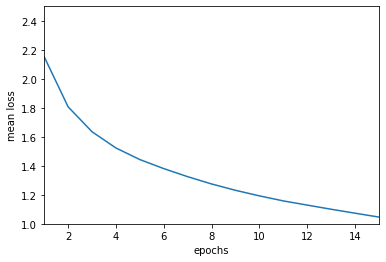

In [22]:
#graph loss over epochs
import matplotlib.pyplot as plt
x_axis = [i for i in range(1, NUM_EPOCHS+1)]
print(x_axis)
plt.xlabel('epochs')
plt.ylabel('mean loss')
plt.axis([1, NUM_EPOCHS, 1, 2.5])
plt.plot(x_axis, avg_losses)